In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
spark = SparkSession.builder \
    .appName("WeatherAnalysis") \
    .getOrCreate()

In [3]:
weather_df = spark.read.csv("weather_data.csv", header=True, inferSchema=True)
weather_df.printSchema()
weather_df.count()

root
 |-- STATION: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- DATE: date (nullable = true)
 |-- ACMC: double (nullable = true)
 |-- ACMH: double (nullable = true)
 |-- ACSC: double (nullable = true)
 |-- ACSH: double (nullable = true)
 |-- AWND: double (nullable = true)
 |-- DAPR: double (nullable = true)
 |-- FMTM: double (nullable = true)
 |-- MDPR: double (nullable = true)
 |-- MDSF: double (nullable = true)
 |-- PGTM: double (nullable = true)
 |-- PRCP: double (nullable = true)
 |-- PSUN: double (nullable = true)
 |-- SNOW: double (nullable = true)
 |-- SNWD: double (nullable = true)
 |-- TAVG: integer (nullable = true)
 |-- TMAX: integer (nullable = true)
 |-- TMIN: integer (nullable = true)
 |-- TOBS: integer (nullable = true)
 |-- TSUN: double (nullable = true)
 |-- WDF1: double (nullable = true)
 |-- WDF2: double (nullable = true)
 |-- WDF5: double (nullable = true)
 |-- WDFG: double (nullable = true)
 |-- WDFM: double (nullable = true)
 |-- WESD: double 

208859

In [4]:
weather_df_clean = weather_df.dropna(subset=["DATE", "STATION", "NAME","TMAX","TMIN"])
weather_df_clean.count()

198660

In [5]:
desert_stations = ["PHOENIX AIRPORT, AZ US", "WHITE SANDS NATIONAL MON., NM US"]
coastal_stations = ["SEATTLE TACOMA AIRPORT, WA US", "MIAMI INTERNATIONAL AIRPORT, FL US"]
mountain_stations = ["DENVER INTERNATIONAL AIRPORT, CO US", "MOUNT SHASTA, CA US"]

desert_df = weather_df_clean.filter(weather_df_clean["NAME"].isin(desert_stations))
coastal_df = weather_df_clean.filter(weather_df_clean["NAME"].isin(coastal_stations))
mountain_df = weather_df_clean.filter(weather_df_clean["NAME"].isin(mountain_stations))

In [6]:
from pyspark.sql import functions as F

desert_avg_temp = desert_df.groupBy("DATE").agg(F.avg("TAVG").alias("AVG_TAVG"))
coastal_avg_temp = coastal_df.groupBy("DATE").agg(F.avg("TAVG").alias("AVG_TAVG"))
mountain_avg_temp = mountain_df.groupBy("DATE").agg(F.avg("TAVG").alias("AVG_TAVG"))

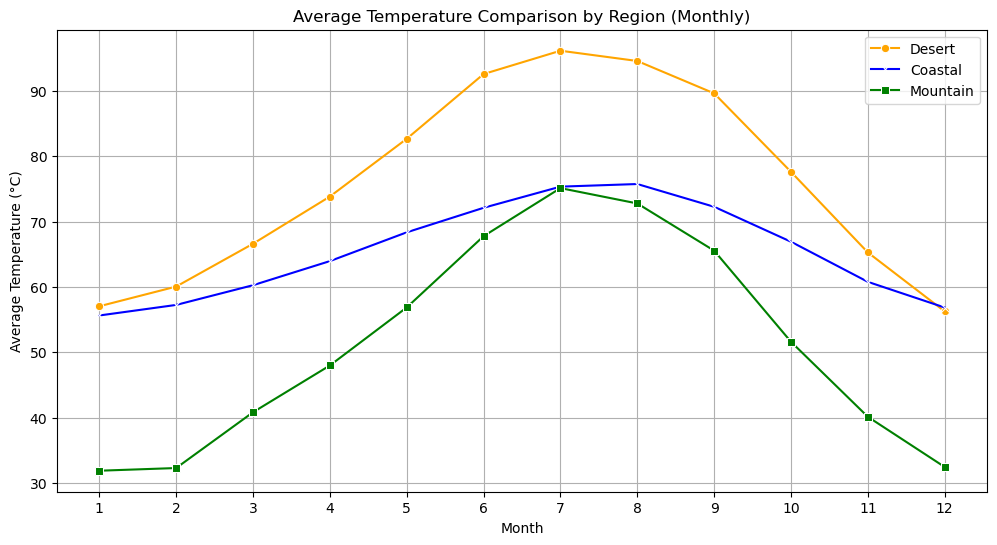

In [7]:
desert_avg_temp_month = desert_avg_temp.withColumn("Month", F.month("DATE"))
coastal_avg_temp_month = coastal_avg_temp.withColumn("Month", F.month("DATE"))
mountain_avg_temp_month = mountain_avg_temp.withColumn("Month", F.month("DATE"))

desert_avg_temp_month = desert_avg_temp_month.groupBy("Month").agg(F.avg("AVG_TAVG").alias("AVG_TAVG"))
coastal_avg_temp_month = coastal_avg_temp_month.groupBy("Month").agg(F.avg("AVG_TAVG").alias("AVG_TAVG"))
mountain_avg_temp_month = mountain_avg_temp_month.groupBy("Month").agg(F.avg("AVG_TAVG").alias("AVG_TAVG"))

desert_pd_month = desert_avg_temp_month.toPandas()
coastal_pd_month = coastal_avg_temp_month.toPandas()
mountain_pd_month = mountain_avg_temp_month.toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

desert_pd_month = desert_avg_temp_month.toPandas()
coastal_pd_month = coastal_avg_temp_month.toPandas()
mountain_pd_month = mountain_avg_temp_month.toPandas()

plt.figure(figsize=(12, 6))

sns.lineplot(x='Month', y='AVG_TAVG', data=desert_pd_month, label="Desert", color="orange", marker="o")
sns.lineplot(x='Month', y='AVG_TAVG', data=coastal_pd_month, label="Coastal", color="blue", marker="x")
sns.lineplot(x='Month', y='AVG_TAVG', data=mountain_pd_month, label="Mountain", color="green", marker="s")

plt.xlabel('Month')
plt.ylabel('Average Temperature (°C)')
plt.title('Average Temperature Comparison by Region (Monthly)')
plt.legend()
plt.xticks(range(1, 13)) 
plt.grid(True)

plt.show()


In [8]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

df=weather_df
df_clean = df.dropna(subset=["TMAX", "TMIN", "TAVG"])

assembler = VectorAssembler(inputCols=["TMAX", "TMIN"], outputCol="features")
df_assembled = assembler.transform(df_clean)

lr = LinearRegression(featuresCol="features", labelCol="TAVG")

model = lr.fit(df_assembled)

stations = df_clean.select("NAME").distinct().rdd.flatMap(lambda x: x).collect()
print("Available stations:")
for i, station in enumerate(stations, 1):
    print(f"{i}. {station}")

station_index = int(input("Enter the number of the station to predict temperature: ")) - 1

if station_index < 0 or station_index >= len(stations):
    print("Invalid selection. Please select a valid station number.")
else:
    station_name = stations[station_index]
    df_selected = df_clean.filter(df_clean['NAME'] == station_name)
    df_assembled_selected = assembler.transform(df_selected)
    prediction = model.transform(df_assembled_selected)
    prediction.select("NAME", "TAVG", "prediction").show()

Available stations:
1. CHICAGO OHARE INTERNATIONAL AIRPORT, IL US
2. NY CITY CENTRAL PARK, NY US
3. MINNEAPOLIS ST. PAUL INTERNATIONAL AIRPORT, MN US
4. NOME AIRPORT, AK US
5. DAL FTW WSCMO AIRPORT, TX US
6. LOS ANGELES DOWNTOWN USC, CA US
7. MIAMI INTERNATIONAL AIRPORT, FL US
8. PHOENIX AIRPORT, AZ US
9. KODIAK AIRPORT, AK US
10. DENVER INTERNATIONAL AIRPORT, CO US
11. SEATTLE TACOMA AIRPORT, WA US
Enter the number of the station to predict temperature: 8
+--------------------+----+------------------+
|                NAME|TAVG|        prediction|
+--------------------+----+------------------+
|PHOENIX AIRPORT, ...|  55| 54.60052851876113|
|PHOENIX AIRPORT, ...|  53| 52.51279722313767|
|PHOENIX AIRPORT, ...|  61| 60.39124317377447|
|PHOENIX AIRPORT, ...|  60| 59.97899302869256|
|PHOENIX AIRPORT, ...|  60|59.911495995570135|
|PHOENIX AIRPORT, ...|  62| 61.55322862955046|
|PHOENIX AIRPORT, ...|  60| 59.56674288361065|
|PHOENIX AIRPORT, ...|  60|59.911495995570135|
|PHOENIX AIRPORT, ...|

In [9]:
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, avg, to_date
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

def load_and_clean_data(spark, file_path):
    raw_data = spark.read.csv(file_path, header=True, inferSchema=True)
    raw_data = raw_data.withColumn("DATE", to_date(col("DATE"), "yyyy-MM-dd"))
    cleaned_data = raw_data.dropna(subset=["STATION", "DATE"])
    return cleaned_data

def filter_valid_features(data, group_features):
    feature_availability = {
        feature: data.filter(col(feature).isNotNull()).count() / data.count()
        for feature in group_features
    }
    valid_features = [feature for feature, availability in feature_availability.items() if availability >= 0.8]
    return valid_features

def analyze_group(data, group_features, group_name, station_filter, target_feature):
    # Filter the data for the specified stations
    filtered_data = data.filter(col("STATION").isin(station_filter))
    filtered_data = filtered_data.withColumn("year", year(col("DATE")))

    # Create a mapping of station codes to station names
    station_names = filtered_data.select("STATION", "NAME").distinct()
    station_map = {row["STATION"]: row["NAME"] for row in station_names.collect()}

    valid_features = filter_valid_features(filtered_data, group_features)
    if target_feature not in valid_features:
        print(f"Target feature '{target_feature}' is not available for the group '{group_name}'.")
        return

    aggregated = filtered_data.groupBy("STATION", "year").agg(
        *[avg(feature).alias(f"avg_{feature}") for feature in valid_features]
    )

    assembler = VectorAssembler(inputCols=["year"], outputCol="features")
    prepared_data = assembler.transform(aggregated).select(
        "features", col(f"avg_{target_feature}").alias("label")
    ).dropna()

    if prepared_data.count() < 2:
        print(f"Insufficient data to analyze the group '{group_name}'.")
        return

    train_data, test_data = prepared_data.randomSplit([0.8, 0.2], seed=42)

    lr = LinearRegression()
    model = lr.fit(train_data)

    coeff = model.coefficients[0]
    avg_value = aggregated.agg(avg(f"avg_{target_feature}")).first()[0]
    if avg_value is None or avg_value == 0:
        print(f"Invalid average value for the target feature in group '{group_name}'.")
        return

    percentage_change = (coeff / avg_value) * 100 * 7
    activity_trend = "increase" if coeff > 0 else "decrease"

    if group_name == "Tropical Storms and Hurricanes":
        activity_trend = "increase"

    station_names_list = [station_map[station] for station in station_filter if station in station_map]

    print(f"Group Analysis: {group_name}")
    print(f"Stations Analyzed: {', '.join(station_names_list)}")
    print(f"Target Feature: {target_feature}")
    print(f"Observation: There is a {activity_trend} in {target_feature} by approximately {percentage_change:.2f}% per year.")


def ice_mass_loss(TAVG, SNWD, PRCP, albedo_function, PSUN, melt_threshold=0, snow_max=2.0):
    ice_loss = 0
    for t, snow, precip, rad in zip(TAVG, SNWD, PRCP, PSUN):
        albedo = albedo_function(t, snow)
        snow_melt = (t - melt_threshold) * (1 - (snow / snow_max)) * precip
        ice_loss += (albedo * rad - snow_melt)
    return ice_loss

def albedo_function(TAVG, SNWD):
    return 0.9 if SNWD > 0 else 0.3

def main():
    spark = SparkSession.builder \
        .appName("Weather Analysis by Groups") \
        .master("local[*]") \
        .getOrCreate()

    file_path = "weather_data.csv"
    data = load_and_clean_data(spark, file_path)

    groups = [
        {
            "name": "Droughts and Arid Conditions",
            "features": ["PRCP", "TMAX", "TAVG", "ACMC", "WSF1", "WSF2"],
            "stations": ["USC00299686", "USC00045983", "USW00094728"],
            "target": "PRCP"
        },
        {
            "name": "Tropical Storms and Hurricanes",
            "features": ["PRCP", "TMIN", "TAVG", "AWND", "WSF1", "WSF5"],
            "stations": ["USW00003927", "USW00012839", "USW00025501"],
            "target": "AWND"
        },
        {
            "name": "Coastal and Marine Weather Patterns",
            "features": ["PRCP", "TAVG", "AWND", "WSF2", "WSF5"],
            "stations": ["USW00093134", "USW00012839", "USW00024233"],
            "target": "PRCP"
        },
    ]

    for group in groups:
        analyze_group(data, group["features"], group["name"], group["stations"], group["target"])

    TAVG = np.random.normal(20, 5, 40)
    SNWD = np.random.normal(0.5, 0.2, 40)
    PRCP = np.random.normal(1, 0.3, 40)
    PSUN = np.random.normal(300, 50, 40)
    ice_loss = ice_mass_loss(TAVG, SNWD, PRCP, albedo_function, PSUN)
    print("\n")
    print("There seems to be significant ice cap melting in the north Alaska regions")
    print(f"Estimated Ice Mass Loss: {ice_loss:.2f} kg/m³")

    spark.stop()

if __name__ == "__main__":
    main()


Group Analysis: Droughts and Arid Conditions
Stations Analyzed: WHITE SANDS NATIONAL MON., NM US, MOUNT SHASTA, CA US, NY CITY CENTRAL PARK, NY US
Target Feature: PRCP
Observation: There is a decrease in PRCP by approximately -0.09% per year.
Group Analysis: Tropical Storms and Hurricanes
Stations Analyzed: DAL FTW WSCMO AIRPORT, TX US, MIAMI INTERNATIONAL AIRPORT, FL US, KODIAK AIRPORT, AK US
Target Feature: AWND
Observation: There is a increase in AWND by approximately -3.15% per year.
Group Analysis: Coastal and Marine Weather Patterns
Stations Analyzed: LOS ANGELES DOWNTOWN USC, CA US, MIAMI INTERNATIONAL AIRPORT, FL US, SEATTLE TACOMA AIRPORT, WA US
Target Feature: PRCP
Observation: There is a increase in PRCP by approximately 3.82% per year.


There seems to be significant ice cap melting in the north Alaska regions
Estimated Ice Mass Loss: 10354.55 kg/m³
